# Bypass the RL, win money 🤑

This notebook is a pipeline for designing an efficient model for AWS Deepracer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
from copy import copy
from time import time

# Part 1 - Compute the optimal racing line

In [2]:
TRACK_NAME = 'Aragon'
NUMBER_STEPS_PER_SECOND = 15 

In [3]:
action_space = pd.DataFrame(columns = ['id', 'speed', 'steering'])
action_sequence = []
optimal_racing_line = pd.DataFrame(columns = ['x', 'y', 'speed', 'distance_from_last_point'])

### Load the appropriate Track

In [4]:
# Load the waypoints
waypoints = np.load("../tracks/" + TRACK_NAME + ".npy")

# Build the geometrical objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [5]:
def print_shape(ax, shape, color='cyan'):
    line = LineString(shape)
    x, y = line.xy                                                                
    ax.plot(x, y, '.', color='gray')   
    ax.plot(x, y, color=color, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2) 

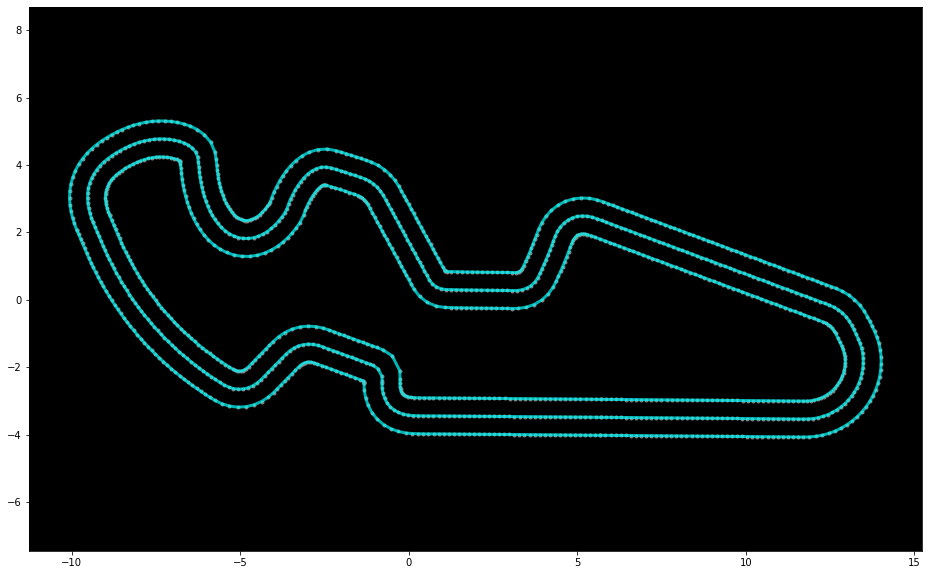

In [6]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_shape(ax, center_line)
print_shape(ax, inner_border)
print_shape(ax, outer_border)

# Part 2 - Compute the action space

# Part 3 - Compute the optimal racing line using only actions from the action space

### Mock (useful only for coding part 3 alone)

In [7]:
# Hardcoded action space to work with real values
action_space = [[0,-2.1672,1.8288], [1,4.7048,3.746], [2,-0.5041,2.631], [3,-8.4625,1.7638], [4,9.4065,1.3834], [5,4.8393,2.1362], [6,-2.4795,2.1993], [7,-1.2504,3.1708], [8,-5.5957,1.5737], [9,-0.4535,3.9733], [10,4.7458,1.8055], [11,7.6023,2.5505], [12,-3.6409,3.653], [13,0.2825,1.5781], [14,-12.393,1.5628], [15,-9.039,2.4206], [16,10.9898,1.7996], [17,30.0,1.33], [18,-30.0,1.33], [19,-0.9195,4.0], [20,0.0,4.0]]
action_space = pd.DataFrame(action_space, columns=('id','steering','speed'))

# Mock racing line, to work with it
optimal_racing_line = [[5.69112, -3.48531, 4.0, 0.03756],
                        [5.54088, -3.484, 4.0, 0.03756],
                        [5.39063, -3.4827, 4.0, 0.03756],
                        [5.24039, -3.48138, 4.0, 0.03756],
                        [5.09015, -3.48007, 4.0, 0.03756],
                        [4.93991, -3.47876, 4.0, 0.03756],
                        [4.78967, -3.47744, 4.0, 0.03756],
                        [4.63943, -3.47613, 4.0, 0.03756],
                        [4.48918, -3.47481, 4.0, 0.03756],
                        [4.33894, -3.47349, 4.0, 0.03756],
                        [4.1887, -3.47217, 4.0, 0.03756],
                        [4.03846, -3.47086, 4.0, 0.03756],
                        [3.88822, -3.46955, 4.0, 0.03756],
                        [3.73798, -3.46825, 4.0, 0.03756],
                        [3.58773, -3.46697, 4.0, 0.03756],
                        [3.43749, -3.46569, 4.0, 0.03756],
                        [3.28725, -3.46441, 4.0, 0.03756],
                        [3.13701, -3.46315, 4.0, 0.03756],
                        [2.98677, -3.46189, 4.0, 0.03756],
                        [2.83653, -3.46061, 4.0, 0.03756],
                        [2.68628, -3.45929, 4.0, 0.03756],
                        [2.53604, -3.45791, 4.0, 0.03756],
                        [2.3858, -3.45648, 3.88779, 0.03865],
                        [2.23556, -3.45501, 3.33085, 0.04511],
                        [2.08532, -3.45349, 2.97704, 0.05047],
                        [1.93508, -3.4521, 2.73273, 0.05498],
                        [1.78519, -3.45017, 2.55159, 0.05875],
                        [1.63603, -3.44682, 2.41431, 0.0618],
                        [1.48801, -3.44123, 2.32439, 0.06373],
                        [1.34152, -3.43265, 2.25468, 0.06508],
                        [1.19692, -3.42045, 2.21245, 0.06559],
                        [1.05455, -3.40412, 2.18594, 0.06556],
                        [0.91469, -3.38323, 2.18125, 0.06483],
                        [0.7776, -3.35745, 2.18125, 0.06395],
                        [0.64344, -3.32663, 2.18125, 0.06311],
                        [0.51234, -3.29066, 2.18125, 0.06232],
                        [0.38438, -3.24956, 2.18125, 0.06162],
                        [0.25959, -3.20339, 2.18125, 0.061],
                        [0.13797, -3.15228, 2.18922, 0.06026],
                        [0.01946, -3.09641, 2.20286, 0.05948],
                        [-0.09597, -3.03595, 2.23447, 0.05832],
                        [-0.2084, -2.97111, 2.27689, 0.057],
                        [-0.31793, -2.90212, 2.33568, 0.05542],
                        [-0.42468, -2.82925, 2.40798, 0.05368],
                        [-0.52879, -2.75275, 2.47908, 0.05211],
                        [-0.63036, -2.67286, 2.54512, 0.05077],
                        [-0.72953, -2.58984, 2.33663, 0.05535],
                        [-0.82645, -2.50395, 2.18639, 0.05923],
                        [-0.92125, -2.41544, 2.05417, 0.06314],
                        [-1.01395, -2.32461, 1.96288, 0.06612],
                        [-1.10926, -2.2359, 1.88752, 0.06899],
                        [-1.20773, -2.14986, 1.82659, 0.07159],
                        [-1.30986, -2.06714, 1.77871, 0.07389],
                        [-1.41605, -1.98845, 1.75053, 0.0755],
                        [-1.52658, -1.91463, 1.73679, 0.07653],
                        [-1.6415, -1.84653, 1.73026, 0.0772],
                        [-1.76067, -1.78504, 1.73026, 0.0775],
                        [-1.88372, -1.73102, 1.73026, 0.07767],
                        [-2.01011, -1.68524, 1.73026, 0.07769],
                        [-2.13917, -1.64825, 1.73026, 0.07759],
                        [-2.27014, -1.62035, 1.73026, 0.0774],
                        [-2.40235, -1.60169, 1.74009, 0.07673],
                        [-2.53516, -1.59216, 1.76027, 0.07564],
                        [-2.66804, -1.59154, 1.80143, 0.07377],
                        [-2.80059, -1.59937, 1.85493, 0.07158],
                        [-2.9325, -1.61518, 1.92612, 0.06898],
                        [-3.06358, -1.63837, 2.01798, 0.06597],
                        [-3.19372, -1.66831, 2.13711, 0.06248],
                        [-3.32288, -1.7043, 2.28136, 0.05877],
                        [-3.45106, -1.74565, 2.48755, 0.05415],
                        [-3.57836, -1.79154, 2.74645, 0.04927],
                        [-3.70487, -1.8412, 2.47904, 0.05482],
                        [-3.83074, -1.89378, 2.25269, 0.06056],
                        [-3.95614, -1.94848, 2.08843, 0.06551],
                        [-4.07834, -2.00044, 1.96898, 0.06744],
                        [-4.20087, -2.05005, 1.87959, 0.07033],
                        [-4.32386, -2.09625, 1.81954, 0.07221],
                        [-4.44742, -2.13803, 1.78066, 0.07325],
                        [-4.57162, -2.17458, 1.7596, 0.07357],
                        [-4.69648, -2.20516, 1.75385, 0.0733],
                        [-4.822, -2.22912, 1.75385, 0.07286],
                        [-4.94815, -2.24591, 1.75385, 0.07256],
                        [-5.07486, -2.25511, 1.75385, 0.07244],
                        [-5.20202, -2.25639, 1.75385, 0.07251],
                        [-5.3295, -2.24948, 1.75385, 0.07279],
                        [-5.45715, -2.23422, 1.76537, 0.07282],
                        [-5.58478, -2.21051, 1.78431, 0.07275],
                        [-5.7122, -2.17831, 1.81728, 0.07232],
                        [-5.83919, -2.13762, 1.86241, 0.0716],
                        [-5.96551, -2.08856, 1.91944, 0.0706],
                        [-6.09092, -2.03131, 1.99264, 0.06918],
                        [-6.21516, -1.96618, 2.06814, 0.06783],
                        [-6.33796, -1.8935, 2.16851, 0.0658],
                        [-6.45904, -1.81382, 2.29214, 0.06324],
                        [-6.57817, -1.7278, 2.42932, 0.06048],
                        [-6.6951, -1.63624, 2.60364, 0.05704],
                        [-6.80963, -1.54004, 2.81454, 0.05314],
                        [-6.92166, -1.44017, 3.08065, 0.04872],
                        [-7.03129, -1.33747, 3.43572, 0.04372],
                        [-7.13886, -1.23263, 3.61215, 0.04159],
                        [-7.24453, -1.12587, 3.63397, 0.04133],
                        [-7.34828, -1.01727, 3.65319, 0.04111],
                        [-7.4501, -0.90688, 3.66356, 0.04099],
                        [-7.54997, -0.79474, 3.66707, 0.04095],
                        [-7.64787, -0.68089, 3.66707, 0.04095],
                        [-7.74377, -0.56537, 3.66707, 0.04094],
                        [-7.83763, -0.44821, 3.67127, 0.04089],
                        [-7.92944, -0.32945, 3.67365, 0.04086],
                        [-8.01917, -0.20913, 3.68447, 0.04074],
                        [-8.10681, -0.08729, 3.71089, 0.04044],
                        [-8.19235, 0.036, 3.74299, 0.04009],
                        [-8.27582, 0.16071, 3.78922, 0.0396],
                        [-8.35725, 0.28674, 3.83053, 0.03917],
                        [-8.43666, 0.41406, 3.88715, 0.0386],
                        [-8.51408, 0.54259, 3.94659, 0.03802],
                        [-8.58958, 0.67228, 4.0, 0.03751],
                        [-8.66317, 0.80306, 3.70761, 0.04047],
                        [-8.7349, 0.93488, 3.19446, 0.04698],
                        [-8.80479, 1.06771, 2.83599, 0.05292],
                        [-8.87287, 1.2015, 2.58885, 0.05798],
                        [-8.93915, 1.33621, 2.39706, 0.06263],
                        [-9.00363, 1.47182, 2.25277, 0.06666],
                        [-9.06553, 1.60792, 2.13506, 0.07003],
                        [-9.12292, 1.74205, 2.04481, 0.07135],
                        [-9.17471, 1.87303, 1.96983, 0.0715],
                        [-9.22083, 2.00167, 1.9133, 0.07142],
                        [-9.26128, 2.129, 1.86103, 0.07179],
                        [-9.29599, 2.25594, 1.81994, 0.07231],
                        [-9.32472, 2.38315, 1.78935, 0.07288],
                        [-9.34715, 2.51105, 1.75713, 0.0739],
                        [-9.36287, 2.63987, 1.699422569037166973377, 0.07485],
                        [-9.37147, 2.76963, 1.71513, 0.07582],
                        [-9.37246, 2.90019, 1.70054, 0.07678],
                        [-9.36536, 3.03128, 1.68777, 0.07778],
                        [-9.34978, 3.16248, 1.67805, 0.07873],
                        [-9.3253, 3.29326, 1.6718, 0.07959],
                        [-9.29156, 3.42302, 1.66112, 0.08071],
                        [-9.24831, 3.55109, 1.65639, 0.08161],
                        [-9.19535, 3.67674, 1.64669, 0.08281],
                        [-9.13255, 3.79922, 1.637, 0.08408],
                        [-9.05983, 3.91773, 1.62224, 0.08571],
                        [-8.97719, 4.03145, 1.607, 0.08748],
                        [-8.88467, 4.13949, 1.59009, 0.08945],
                        [-8.78241, 4.2409, 1.57038, 0.09171],
                        [-8.67068, 4.33462, 1.54954, 0.09412],
                        [-8.54996, 4.41946, 1.53461, 0.09615],
                        [-8.42116, 4.49404, 1.5207, 0.09787],
                        [-8.28587, 4.55689, 1.51064, 0.09875],
                        [-8.14629, 4.60677, 1.50432, 0.09854],
                        [-8.00476, 4.64295, 1.50374, 0.09715],
                        [-7.8634, 4.66523, 1.50374, 0.09517],
                        [-7.7239, 4.67399, 1.50374, 0.09295],
                        [-7.58752, 4.66985, 1.50374, 0.09074],
                        [-7.45514, 4.65355, 1.50374, 0.0887],
                        [-7.32738, 4.62585, 1.50374, 0.08693],
                        [-7.20468, 4.58751, 1.50898, 0.08519],
                        [-7.08733, 4.53923, 1.52078, 0.08344],
                        [-6.9755, 4.48167, 1.53648, 0.08186],
                        [-6.86935, 4.41537, 1.55856, 0.0803],
                        [-6.76895, 4.34085, 1.58214, 0.07902],
                        [-6.67442, 4.25852, 1.61433, 0.07765],
                        [-6.5858, 4.16878, 1.6559, 0.07617],
                        [-6.50311, 4.07201, 1.69554, 0.07507],
                        [-6.42641, 3.96849, 1.74552, 0.07381],
                        [-6.35572, 3.85852, 1.79754, 0.07273],
                        [-6.29107, 3.74232, 1.8558, 0.07165],
                        [-6.23249, 3.62009, 1.74212, 0.0778],
                        [-6.18003, 3.4919, 1.64522, 0.08418],
                        [-6.13375, 3.35761, 1.55931, 0.09109],
                        [-6.09354, 3.2161, 1.49866, 0.09817],
                        [-6.0447, 3.07549, 1.44843, 0.10276],
                        [-5.98732, 2.94012, 1.40578, 0.10459],
                        [-5.92111, 2.8116, 1.37257, 0.10533],
                        [-5.84609, 2.69146, 1.34945, 0.10496],
                        [-5.76259, 2.58114, 1.33279, 0.10381],
                        [-5.67128, 2.4817, 1.33, 0.10151],
                        [-5.57301, 2.39395, 1.33, 0.09906],
                        [-5.46871, 2.31851, 1.33, 0.09679],
                        [-5.35933, 2.25577, 1.33, 0.0948],
                        [-5.24587, 2.20595, 1.33, 0.09317],
                        [-5.1293, 2.16916, 1.33, 0.09192],
                        [-5.01052, 2.14527, 1.33545, 0.09072],
                        [-4.89043, 2.1341, 1.34654, 0.08958],
                        [-4.76979, 2.13542, 1.36576, 0.08833],
                        [-4.64935, 2.14896, 1.39321, 0.08699],
                        [-4.52979, 2.17441, 1.43255, 0.08533],
                        [-4.4117, 2.21135, 1.48232, 0.08347],
                        [-4.29563, 2.25927, 1.53951, 06994225690371669.08157],
                        [-4.18203, 2.31767, 1.61135, 0.07927],
                        [-4.07128, 2.38592, 1.69879, 0.07658],
                        [-3.96363, 2.46329, 1.79983, 0.07366],
                        [-3.85924, 2.54902, 1.92859, 0.07004],
                        [-3.75814, 2.6422, 1.97944, 0.06946],
                        [-3.66025, 2.74189, 1.86402, 0.07495],
                        [-3.56533, 2.84704, 1.77575, 0.07977],
                        [-3.47576, 2.95324, 1.703, 0.08158],
                        [-3.38315, 3.05444, 1.64531, 0.08337],
                        [-3.28722, 3.14983, 1.60241, 0.08443],
                        [-3.18774, 3.23871, 1.56508, 0.08523],
                        [-3.0846, 3.32038, 1.53839, 0.08552],
                        [-2.97776, 3.39427, 1.52126, 0.08539],
                        [-2.86729, 3.45985, 1.51333, 0.08489],
                        [-2.75331, 3.51662, 1.51333, 0.08414],
                        [-2.63603, 3.56414, 1.51333, 0.08362],
                        [-2.51572, 3.60197, 1.51333, 0.08334],
                        [-2.39273, 3.62968, 1.51333, 0.08331],
                        [-2.2675, 3.64688, 1.51333, 0.08353],
                        [-2.14056, 3.65327, 1.51372, 0.08396],
                        [-2.01254, 3.64859, 1.52226, 0.08416],
                        [-1.88414, 3.6327, 1.53808, 0.08412],
                        [-1.75613, 3.60557, 1.56043, 0.08386],
                        [-1.62933, 3.5673, 1.5868, 0.08347],
                        [-1.50457, 3.5181, 1.62259, 0.08265],
                        [-1.38266, 3.45838, 1.66784, 0.08139],
                        [-1.26431, 3.38872, 1.71973, 0.07986],
                        [-1.1501, 3.30978, 1.77762, 0.0781],
                        [-1.0405, 3.2223, 1.85001, 0.0758],
                        [-0.93575, 3.12708, 1.93498, 0.07316],
                        [-0.83594, 3.02494, 2.03798, 0.07007],
                        [-0.74097, 2.91667, 2.15722, 0.06676],
                        [-0.65064, 2.80303, 2.30254, 0.06305],
                        [-0.5646, 2.68472, 2.48406, 0.05889],
                        [-0.48242, 2.56243, 2.71598, 0.05425],
                        [-0.4036, 2.43685, 3.01881, 0.04911],
                        [-0.3276, 2.30862, 2.89777, 0.05144],
                        [-0.2538, 2.17836, 2.70879, 0.05527],
                        [-0.18161, 2.04671, 2.5475, 0.05894],
                        [-0.10795, 1.91721, 2.4154, 0.06168],
                        [-0.03242, 1.79023, 2.3116, 0.06391],
                        [0.04528, 1.66623, 2.22678, 0.06571],
                        [0.12545, 1.54567, 2.15799, 0.06709],
                        [0.20834, 1.42892, 2.10316, 0.06808],
                        [0.29418, 1.31638, 2.05771, 0.06879],
                        [0.38317, 1.20837, 2.02033, 0.06927],
                        [0.47545, 1.1052, 1.98639, 0.06969],
                        [0.57117, 1.00709, 1.9589, 0.06997],
                        [0.67039, 0.91427, 1.93772, 0.07012],
                        [0.7732, 0.8269, 1.91423, 0.07048],
                        [0.87965, 0.74516, 1.88707, 0.07112],
                        [0.98978, 0.66922, 1.85931, 0.07195],
                        [1.10365, 0.59926, 1.82827, 0.0731],
                        [1.22133, 0.5355, 1.80233, 0.07426],
                        [1.34286, 0.47815, 1.77845, 0.07556],
                        [1.46834, 0.42752, 1.76769, 0.07655],
                        [1.5979, 0.384, 1.75753, 0.07776],
                        [1.73169, 0.34812, 1.75158, 0.07908],
                        [1.86986, 0.32056, 1.75158, 0.08044],
                        [2.01226, 0.30215, 1.75158, 0.08197],
                        [2.15767, 0.2938, 1.75158, 0.08316],
                        [2.3032, 0.29602, 1.75158, 0.08309],
                        [2.44595, 0.30863, 1.75158, 0.08182],
                        [2.58461, 0.33104, 1.75689, 0.07994],
                        [2.71877, 0.36252, 1.76741, 0.07797],
                        [2.84841, 0.40243, 1.78889, 0.07582],
                        [2.9736, 0.45018, 1.82145, 0.07356],
                        [3.09451, 0.50519, 1.86522, 0.07122],
                        [3.21132, 0.56695, 1.92182, 0.06875],
                        [3.32423, 0.63495, 1.99696, 0.066],
                        [3.43349, 0.70866, 2.08456, 0.06323],
                        [3.53934, 0.78762, 2.19526, 0.06015],
                        [3.64206, 0.8713, 2.33094, 0.05684],
                        [3.74195, 0.95921, 2.50352, 0.05315],
                        [3.83932, 1.05081, 2.61514, 0.05112],
                        [3.9345, 1.14558, 2.34409, 0.0573],
                        [4.02786, 1.243, 2.14322, 0.06295],
                        [4.11971, 1.34255, 1.98524, 0.06823],
                        [4.20999, 1.43738, 1.85236, 0.07068],
                        [4.30171, 1.52949, 1.74091, 0.07467],
                        [4.39529, 1.61808, 1.64228, 0.07846],
                        [4.49109, 1.70239, 1.55709, 0.08195],
                        [4.58943, 1.78168, 1.55709, 0.08113],
                        [4.69061, 1.85528, 1.55709, 0.08035],
                        [4.79489, 1.92246, 1.55709, 0.07967],
                        [4.90253, 1.98249, 1.55709, 0.07915],
                        [5.01376, 2.03453, 1.55709, 0.07887],
                        [5.1288, 2.07766, 1.59658, 0.07695],
                        [5.24731, 2.11216, 1.63752, 0.07537],
                        [5.36899, 2.13827, 1.6815, 0.07401],
                        [5.4936, 2.15612, 1.72651, 0.07291],
                        [5.62091, 2.16583, 1.77749, 0.07183],
                        [5.75071, 2.16745, 1.8479, 0.07025],
                        [5.88276, 2.16121, 1.93086, 0.06847],
                        [6.01681, 2.14735, 2.03224, 0.06631],
                        [6.15259, 2.12621, 2.15765, 0.06369],
                        [6.28983, 2.09827, 2.31726, 0.06044],
                        [6.42825, 2.06413, 2.52187, 0.05653],
                        [6.56758, 2.02451, 2.8028, 0.05168],
                        [6.70757, 1.98028, 3.19463, 0.04596],
                        [6.848, 1.93241, 3.81805, 0.03886],
                        [6.98867, 1.88195, 4.0, 0.03736],
                        [7.12946, 1.82998, 4.0, 0.03752],
                        [7.27028, 1.77759, 4.0, 0.03756],
                        [7.4111, 1.72521, 4.0, 0.03756],
                        [7.55192, 1.67283, 4.0, 0.03756],
                        [7.69274, 1.62046, 4.0, 0.03756],
                        [7.83357, 1.56808, 4.0, 0.03756],
                        [7.97439, 1.51571, 4.0, 0.03756],
                        [8.11522, 1.46334, 4.0, 0.03756],
                        [8.25604, 1.41097, 4.0, 0.03756],
                        [8.39687, 1.35861, 4.0, 0.03756],
                        [8.5377, 1.30625, 4.0, 0.03756],
                        [8.67853, 1.25389, 4.0, 0.03756],
                        [8.81936, 1.20153, 4.0, 0.03756],
                        [8.96019, 1.14918, 4.0, 0.03756],
                        [9.10102, 1.09683, 4.0, 0.03756],
                        [9.24185, 1.04448, 4.0, 0.03756],
                        [9.38269, 0.99213, 4.0, 0.03756],
                        [9.52352, 0.93978, 4.0, 0.03756],
                        [9.66435, 0.88743, 4.0, 0.03756],
                        [9.80519, 0.8351, 4.0, 0.03756],
                        [9.94603, 0.78278, 4.0, 0.03756],
                        [10.08688, 0.73046, 4.0, 0.03756],
                        [10.22773, 0.67815, 4.0, 0.03756],
                        [10.36858, 0.62586, 4.0, 0.03756],
                        [10.50942, 0.57354, 4.0, 0.03756],
                        [10.65026, 0.52119, 4.0, 0.03756],
                        [10.79107, 0.46881, 4.0, 0.03756],
                        [10.93188, 0.41639, 3.92392, 0.03829],
                        [11.07269, 0.36398, 3.35995, 0.04472],
                        [11.21355, 0.31169, 2.98429, 0.05035],
                        [11.35445, 0.25952, 2.70671, 0.05551],
                        [11.49497, 0.20681, 2.49729, 0.0601],
                        [11.63466, 0.15287, 2.32801, 0.06433],
                        [11.77307, 0.09701, 2.19136, 0.06811],
                        [11.90972, 0.03856, 2.075, 0.07163],
                        [12.04412, -0.0231, 1.98308, 0.07457],
                        [12.17577, -0.08857, 1.90981, 0.07699],
                        [12.30417, -0.1584, 1.84986, 0.07901],
                        [12.4288, -0.23311, 1.80009, 0.08072],
                        [12.54912, -0.31316, 1.7583, 0.08219],
                        [12.66457, -0.39897, 1.72291, 0.08349],
                        [12.77455, -0.49089, 1.69326, 0.08465],
                        [12.87849, -0.58915, 1.66316, 0.086],
                        [12.97575, -0.69389, 1.63688, 0.08732],
                        [13.06565, -0.80515, 1.61072, 0.0888],
                        [13.14743, -0.92281, 1.5872, 0.09028],
                        [13.22031, -1.04661, 1.56832, 0.0916],
                        [13.28348, -1.17608, 1.55349, 0.09273],
                        [13.33605, -1.31059, 1.54261, 0.09362],
                        [13.37721, -1.44929, 1.53569, 0.09421],
                        [13.40621, -1.59121, 1.53248, 0.09452],
                        [13.42239, -1.73521, 1.53248, 0.09456],
                        [13.4253, -1.88006, 1.53248, 0.09454],
                        [13.41467, -2.02445, 1.53248, 0.09447],
                        [13.39045, -2.16701, 1.53248, 0.09436],
                        [13.35282, -2.30637, 1.53248, 0.0942],
                        [13.30215, -2.4412, 1.53658, 0.09374],
                        [13.23908, -2.57029, 1.54366, 0.09307],
                        [13.16439, -2.69258, 1.55485, 0.09216],
                        [13.07895, -2.80719, 1.56971, 0.09107],
                        [12.98371, -2.91342, 1.59194, 0.08962],
                        [12.87965, -3.01078, 1.61787, 0.08808],
                        [12.76774, -3.09895, 1.65799, 0.08593],
                        [12.64898, -3.17787, 1.69996, 0.08388],
                        [12.52424, -3.24757, 1.75301, 0.08151],
                        [12.39437, -3.30822, 1.81927, 0.07879],
                        [12.26015, -3.36017, 1.89985, 0.07575],
                        [12.12231, -3.40387, 1.9863, 0.0728],
                        [11.98143, -3.4398, 2.09374, 0.06944],
                        [11.83809, -3.46854, 2.22267, 0.06577],
                        [11.69277, -3.49075, 2.38192, 0.06172],
                        [11.5459, -3.50715, 2.58172, 0.05724],
                        [11.39785, -3.5185, 2.83943, 0.05229],
                        [11.24893, -3.52562, 3.18399, 0.04682],
                        [11.09941, -3.52934, 3.69362, 0.0405],
                        [10.94948, -3.5305, 4.0, 0.03748],
                        [10.79934, -3.52996, 4.0, 0.03754],
                        [10.64909, -3.5286, 4.0, 0.03756],
                        [10.49885, -3.52726, 4.0, 0.03756],
                        [10.34861, -3.52592, 4.0, 0.03756],
                        [10.19837, -3.5246, 4.0, 0.03756],
                        [10.04813, -3.5233, 4.0, 0.03756],
                        [9.89788, -3.522, 4.0, 0.03756],
                        [9.74764, -3.52069, 4.0, 0.03756],
                        [9.5974, -3.51939, 4.0, 0.03756],
                        [9.44716, -3.51808, 4.0, 0.03756],
                        [9.29692, -3.51677, 4.0, 0.03756],
                        [9.14668, -3.51546, 4.0, 0.03756],
                        [8.99643, -3.51415, 4.0, 0.03756],
                        [8.84619, -3.51284, 4.0, 0.03756],
                        [8.69595, -3.51153, 4.0, 0.03756],
                        [8.54571, -3.51021, 4.0, 0.03756],
                        [8.39547, -3.5089, 4.0, 0.03756],
                        [8.24523, -3.50759, 4.0, 0.03756],
                        [8.09498, -3.50628, 4.0, 0.03756],
                        [7.94474, -3.50497, 4.0, 0.03756],
                        [7.7945, -3.50366, 4.0, 0.03756],
                        [7.64426, -3.50235, 4.0, 0.03756],
                        [7.49402, -3.50104, 4.0, 0.03756],
                        [7.34378, -3.49973, 4.0, 0.03756],
                        [7.19353, -3.49842, 4.0, 0.03756],
                        [7.04329, -3.49711, 4.0, 0.03756],
                        [6.89305, -3.4958, 4.0, 0.03756],
                        [6.74281, -3.49448, 4.0, 0.03756],
                        [6.59257, -3.49317, 4.0, 0.03756],
                        [6.44233, -3.49186, 4.0, 0.03756],
                        [6.29208, -3.49055, 4.0, 0.03756],
                        [6.14184, -3.48924, 4.0, 0.03756],
                        [5.9916, -3.48793, 4.0, 0.03756],
                        [5.84136, -3.48662, 4.0, 0.03756]]

optimal_racing_line = pd.DataFrame(optimal_racing_line, columns=['x','y','speed','distance_from_last_point'])

### Utils

In [8]:
def compute_theta_from_coords(x0, x1, y0, y1):
    if x1 == x0:
        if y1 > y0:
            return np.pi / 2
        elif y1 < y0:
            return - np.pi / 2
        else:
            raise("Can't compute an angle when speed is null")
    elif x1 > x0:
        return np.arctan((y1-y0)/(x1-x0))
    else:
        return np.pi + np.arctan((y1-y0)/(x1-x0))

In [9]:
def take_theta_into_minus_pi_pi(theta):
    # Ensure rad_steering is between -pi and pi
    if theta > np.pi:
        return take_theta_into_minus_pi_pi(theta - 2 * np.pi)
    if theta < - np.pi:
        return take_theta_into_minus_pi_pi(theta + 2 * np.pi)
    else:
        return theta

### Compute action sequence

### Easiest method : compute the 'closest action' (lowest  euclidian distance) for each step

In [10]:
# Note: to compute an effective euclidian distance, we need to normalize speed and steering

def compute_action_sequence_euclidian_distance(action_space, optimal_racing_line, theta0):
    
    num_actions = len(optimal_racing_line) - 1
    
    work_optimal_racing_line = pd.concat([pd.DataFrame({
        'x': optimal_racing_line['x'][0] - np.cos(theta0),
        'y': optimal_racing_line['y'][0] - np.sin(theta0),
        'speed': 0,
        'distance_from_last_point': 1
    }, index=[0]), optimal_racing_line]).reset_index(drop=True)
    
    action_sequence = []
    rad_steerings = []
    speeds = []
    for i in range(num_actions): # There is a minus 2 since we need at least 3 points to determine a steering angle
        # Compute geometrical data 
        (x0, x1, x2) = (work_optimal_racing_line['x'][i+k] for k in range(3)) 
        (y0, y1, y2) = (work_optimal_racing_line['y'][i+k] for k in range(3))
        angle_1 = compute_theta_from_coords(x0, x1, y0, y1)
        angle_2 = compute_theta_from_coords(x1, x2, y1, y2)
        rad_steering = take_theta_into_minus_pi_pi(angle_2 - angle_1) # CAREFUL : those are radiants
        rad_steerings.append(rad_steering)
        speed = ((x1 - x0)**2 + (y1 - y0)**2)**0.5 * NUMBER_STEPS_PER_SECOND
        speeds.append(speed)
    # Compute distribution caracteristics, for normalization
    mean_rad_steering = np.mean(rad_steerings)
    std_rad_steering = np.std(rad_steerings)
    mean_speed = np.mean(speeds)
    std_speed = np.std(speeds)
    
    for i in range(num_actions):
        # Normalization
        normalized_rad_steering = (rad_steerings[i] - mean_rad_steering) / std_rad_steering
        normalized_speed = (speeds[i] - mean_speed) / std_speed
        
        # The optimal action
        opt_action = np.array([normalized_rad_steering, normalized_speed])
        
        # Find the closest action from our action space (lowest euclidian distance)
        chosen_action_id = 0
        chosen_action_distance = 1000
        for j in range(len(action_space)):
            # Normalization
            normalized_cur_rad_steering =  (action_space['steering'][j]*2*np.pi/360 - mean_rad_steering) / std_rad_steering
            normalized_cur_speed =  (action_space['speed'][j] - mean_speed) / std_speed
            
            # The current considered action
            cur_action = np.array([normalized_cur_rad_steering, normalized_cur_speed])
            
            distance_to_optimal = np.linalg.norm(opt_action - cur_action)
            
            if distance_to_optimal < chosen_action_distance:
                chosen_action_id = action_space['id'][j]
                chosen_action_distance = distance_to_optimal
        action_sequence.append(chosen_action_id)
    
    return action_sequence

In [11]:
action_sequence = compute_action_sequence_euclidian_distance(action_space, optimal_racing_line, 0)

### A more complicated method : genetical algorithm

In [28]:
# Helpers, used in almost every functions
[x0, y0] = center_line[0]
theta0 = - np.pi

# Check if point (x, y) is in the track
def check_if_car_in_track(x, y):
    point = Point(x, y)
    inner_polygon = Polygon(inner_border)
    outer_polygon = Polygon(outer_border)
    if outer_polygon.contains(point) and not inner_polygon.contains(point):
        return True
    else:
        return False

# Euclidian distance
def distance(x1, y1, x2, y2):
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

# Check the closest point from track from (x,y) and measure percentage of completion with this point
# Note: we need to include last percentage to handle multilaps
def get_percentage_completion(x, y, last_percentage):
    d = 1000
    index = 0
    for i, p in enumerate(center_line):
        cur_d = distance(p[0], p[1], x, y)
        if cur_d < d:
            index = i
            d = cur_d
    percentage = index * 100 / len(center_line)
    while (np.abs(100+percentage - last_percentage) < np.abs(percentage - last_percentage)):
        percentage += 100
           
    return percentage

# Return percentage completion before the 1st out of track. 
# Return this percentage, the number of steps before 1st out of track, and wether there was an out of track or not
def get_percentage(action_sequence, verbose=False):
    cur_x = x0
    cur_y = y0
    cur_theta = theta0
    counter = 0
    car_in_track = False
    last_percentage = 0  # Initial percentage of completion is 0
    for action_id in action_sequence:
        counter += 1
        speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
        steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
        cur_theta += steering * 2 * np.pi / 360
        cur_x += np.cos(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        cur_y += np.sin(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        
        if verbose:
            print(cur_x, cur_y)
            print(speed, steering)
        
        percentage_completion = get_percentage_completion(cur_x, cur_y, last_percentage)
        last_percentage = percentage_completion
        
        if not check_if_car_in_track(cur_x, cur_y):
            if verbose:
                print(cur_x, cur_y)
            
            return percentage_completion, counter, car_in_track
    
    car_in_track = True
    return percentage_completion, counter, car_in_track

In [29]:
# Make mutations.
# Insertion and mutations are made. Control with insertion_rate
# Look_backward tells you how much base you should look at for performing a mutation
# For example, a look_backward of 20 tells you that the function will only perform mutations on the last 20 bases
# Note that last bases are most likely mutated
def make_mutations(action_sequence, n_individuals, n_mutations, insertion_rate, look_backward):
    mutated_action_sequences = []
    n = len(action_sequence)
    for i in range(n_individuals):
        mutated_action_sequences.append(copy(action_sequence))
        for j in range(n_mutations):
            action = np.random.randint(len(action_space))
            insertion = np.random.rand() > 1 - insertion_rate
            if insertion:
                mutated_action_sequences[i].append(action)
            else:
                index = np.random.choice(np.arange(max(0, n-look_backward) , n), p=np.arange(max(0, n-look_backward), n) / np.sum(np.arange(max(0, n-look_backward), n)))
                mutated_action_sequences[i][index] = action
    return mutated_action_sequences

# Define the reward
# The reward is proportional to the percentage of completion of the circuit / number of actions to complete this percentage
# The percentage_power parameter allows you to define wheter it is important to go fast (low percentage power) or finish track (high percentage power)
# If the circuit is complete (100% completion), the only metric is the number of actions
def get_fitness(action_sequence, n_laps, percentage_power=2):
    percentage, number_action, car_in_track = get_percentage(action_sequence)
    percentage = min(100 * n_laps, percentage)  # If car has finished track, the percentage stays at 100 * n_laps
    fitness = percentage**percentage_power * 15 / number_action
    return fitness, car_in_track

In [32]:
# Evolutionary algorithm, here a 1 + n_individuals algorithm

def compute_action_sequence_evolutionary_algorithm(
    n_laps=3, 
    n_epochs=100, 
    n_individuals=100,
    n_mutations=5,
    insertion_rate=0.5,
    look_backward=20,
    get_intermediary_action_sequence=False, 
    number_intermediary_sequences=6):
    
    current_action_sequence = [0, 0]
    
    fitness_values = []
    best_fitness_values = []
    
    N_EPOCHS = n_epochs
    intermediary_sequences = []
    timer = time()
    for epoch in range(N_EPOCHS):
        if (epoch + 1) % (N_EPOCHS // 40) == 0:
            print(f"Epoch {epoch + 1}")
            print(f"Solution is {len(current_action_sequence)} long")
            print(f"Average time for 1 epoch : {(time() - timer) / (N_EPOCHS // 40): .2f} sec")
            timer = time()
        if epoch % (N_EPOCHS // number_intermediary_sequences) == 0:
            intermediary_sequences.append(current_action_sequence)
        # Make mutations of the best current solution
        mutated_action_sequences = make_mutations(
            current_action_sequence, 
            n_individuals=n_individuals, 
            n_mutations=n_mutations,
            insertion_rate=insertion_rate,
            look_backward=look_backward
        ) + [current_action_sequence]

        # The current best reward
        best_fitness, _ = get_fitness(current_action_sequence, n_laps)

        # Check 
        for mutated_action_sequence in mutated_action_sequences:
            fitness, car_in_track = get_fitness(mutated_action_sequence, n_laps)
            if not car_in_track:
                continue
            fitness_values.append(fitness)
            best_fitness_values.append(best_fitness)
            
            if fitness > best_fitness:
                best_fitness = fitness
                current_action_sequence = mutated_action_sequence
    
    plt.plot(fitness_values)
    plt.plot(best_fitness_values)
    plt.show()
    
    if get_intermediary_action_sequence:
        return current_action_sequence, intermediary_sequences
    return current_action_sequence

Epoch 4
Solution is 19 long
Average time for 1 epoch :  0.62 sec
Epoch 9
Solution is 46 long
Average time for 1 epoch :  2.15 sec
Epoch 14
Solution is 69 long
Average time for 1 epoch :  3.98 sec
Epoch 19
Solution is 91 long
Average time for 1 epoch :  5.76 sec
Epoch 24
Solution is 110 long
Average time for 1 epoch :  7.54 sec
Epoch 29
Solution is 133 long
Average time for 1 epoch :  9.88 sec
Epoch 34
Solution is 155 long
Average time for 1 epoch :  11.50 sec
Epoch 39
Solution is 175 long
Average time for 1 epoch :  13.14 sec
Epoch 44
Solution is 196 long
Average time for 1 epoch :  15.64 sec
Epoch 49
Solution is 215 long
Average time for 1 epoch :  16.41 sec
Epoch 54
Solution is 237 long
Average time for 1 epoch :  17.33 sec
Epoch 59
Solution is 258 long
Average time for 1 epoch :  18.50 sec
Epoch 64
Solution is 281 long
Average time for 1 epoch :  20.03 sec
Epoch 69
Solution is 307 long
Average time for 1 epoch :  22.27 sec
Epoch 74
Solution is 328 long
Average time for 1 epoch :  24

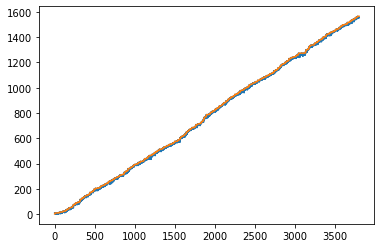

In [33]:
action_sequence = compute_action_sequence_evolutionary_algorithm(
    n_laps=3, 
    n_epochs=200,
    n_individuals=50,
    n_mutations=6,
    insertion_rate=0.6,
    look_backward=20
)

### Plot the action sequence

In [34]:
def compute_real_racing_line(action_sequence, action_space, x0, y0, theta0):
    xs = [x0]
    ys = [y0]

    cur_x = x0
    cur_y = y0
    cur_theta = theta0
    for action_id in action_sequence:
        speed = action_space.loc[action_space['id'] == action_id]['speed'].values[0]
        steering = action_space.loc[action_space['id'] == action_id]['steering'].values[0]
        cur_theta += steering * 2 * np.pi / 360
        cur_x += np.cos(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        cur_y += np.sin(cur_theta) * speed / NUMBER_STEPS_PER_SECOND
        xs.append(cur_x)
        ys.append(cur_y)
    real_racing_line = pd.DataFrame({
        'x': xs,
        'y': ys
    })
    return real_racing_line

In [35]:
real_racing_line = compute_real_racing_line(
    action_sequence, 
    action_space, 
    x0=optimal_racing_line['x'][0],
    y0=optimal_racing_line['y'][0],
    theta0=theta0
)

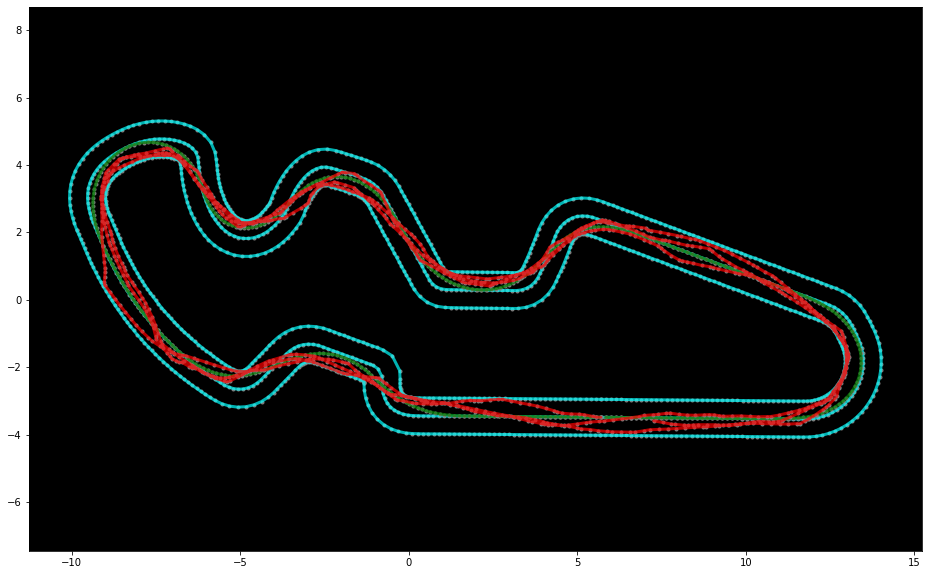

In [36]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_shape(ax, center_line)
print_shape(ax, inner_border)
print_shape(ax, outer_border)
print_shape(ax, optimal_racing_line.drop(columns=['speed', 'distance_from_last_point']).values, color='green')
print_shape(ax, real_racing_line.values, color='red')

The blue line is the optimal racing line

The red line is the computed racing line, using only the actions from the action space

# Part 4 - Build the reward function